In [233]:
import cv2
import numpy as np
import sys
import getopt
import operator
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpim

In [234]:
def getMatrix(matrix, curr_x, curr_y, v_boundry,  h_boundary):
    return matrix[curr_x - v_boundry:curr_x + h_boundary,curr_y - v_boundry: curr_y + h_boundary]


def findCorners(img, window_size, k, thresh):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]
    
    cornerList = []
    newImg = img.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    offset = math.floor(window_size/2)

    
    # Loop through image and find our corners
    # and do non-maximum supression
    # this can be also implemented without loop
    
    print("Finding Corners...")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            X_component = getMatrix(Ixx, y,x, offset, offset+1)
            Y_component = getMatrix(Iyy, y,x, offset, offset+1)
            XY_component = getMatrix(Ixy, y,x, offset, offset+1)

            Mxx = np.sum(X_component)
            Myy = np.sum(Y_component)
            Mxy = np.sum(XY_component)

            determinant = (Mxx * Myy) - (Mxy**2)
            trace = Mxx + Myy
            response = determinant - k * (trace**2)

            if response > thresh:
                cornerList.append([x,y,response]);
                color_img.itemset((y,x, 0), 0)
                color_img.itemset((y,x, 1), 0)
                color_img.itemset((y,x, 2), 255)
    

    return color_img, cornerList

In [235]:
def findGradMagnitude(img):
    Iy, Ix = np.gradient(img) 
    sum_of_sqares =  np.square(Iy) + np.square(Ix)
    gradient_magnitude = np.sqrt(sum_of_sqares)
    plt.imshow(gradient_magnitude,cmap='gray')

In [236]:
def findOrientation(img):
    Iy, Ix = np.gradient(img) 
    theta = np.arctan(Iy/Ix)
    plt.imshow(theta)

In [238]:
pts = []
def main():
    """
    Main parses argument list and runs findCorners() on the image
    :return: None
    """
    # args, img_name = getopt.getopt(sys.argv[1:], '', ['window_size=', 'alpha=', 'corner_threshold='])
    # args = dict(args)
    # print(args)
    window_size = 5
    k = 0.04
    thresh = 10000
    img_name = "hw3_images/house1.jpg"

    print("Image Name: " + str(img_name))
    print("Window Size: " + str(window_size))
    print("K alpha: " + str(k))
    print("Corner Response Threshold:" + str(thresh))

    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(img.shape[0], img.shape[1])
#     finalImg, cornerList = findCorners(img, int(window_size), float(k), int(thresh))
        
#     points = np.array(cornerList)
#     plot = plt.figure(1)        
#     plt.imshow(img,cmap='gray')  
#     plt.plot(points[:,0],points[:,1],'b.',markersize=0.09)    
#     plt.ylabel("y-axis")
#     plt.xlabel("x-axis")
#     plt.show()
         
#     if finalImg is not None:
#             cv2.imwrite("finalimage.png", finalImg)
#     return points
    # findGradMagnitude(img)
    findOrientation(img)

Image Name: hw3_images/house1.jpg
Window Size: 5
K alpha: 0.04
Corner Response Threshold:10000
960 1280


/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_18097/1493213519.py:3: RuntimeWarning: divide by zero encountered in divide
  theta = np.arctan(Iy/Ix)
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_18097/1493213519.py:3: RuntimeWarning: invalid value encountered in divide
  theta = np.arctan(Iy/Ix)


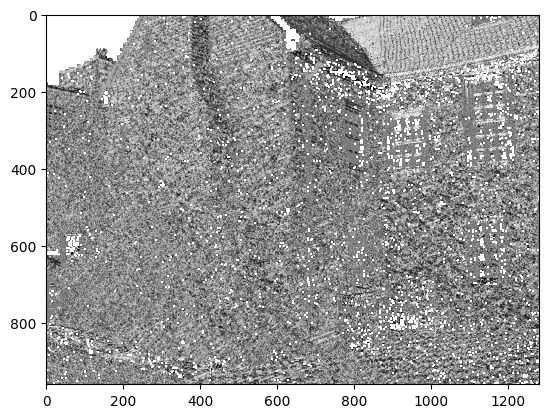

In [239]:
pts = main()

In [125]:
l = x[-19:]

In [126]:
l

array([1277., 1277., 1277., 1277., 1277., 1277., 1277., 1277., 1277.,
       1277., 1277., 1277., 1277., 1277., 1277., 1277., 1277., 1277.,
       1277.])

In [53]:
x

array([   2.,    2.,    2., ..., 1277., 1277., 1277.])